#**Data Exploration and Pre-Processing**

In [1]:
import pandas as pd
import numpy as np
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
breast_cancer = sklearn.datasets.load_breast_cancer()

In [3]:
data = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)

In [4]:
data['class'] = breast_cancer.target

In [5]:
X = data.drop('class', axis=1)
Y = data['class']

In [6]:
len(X.columns)

30

Classes: Malignant and Benign

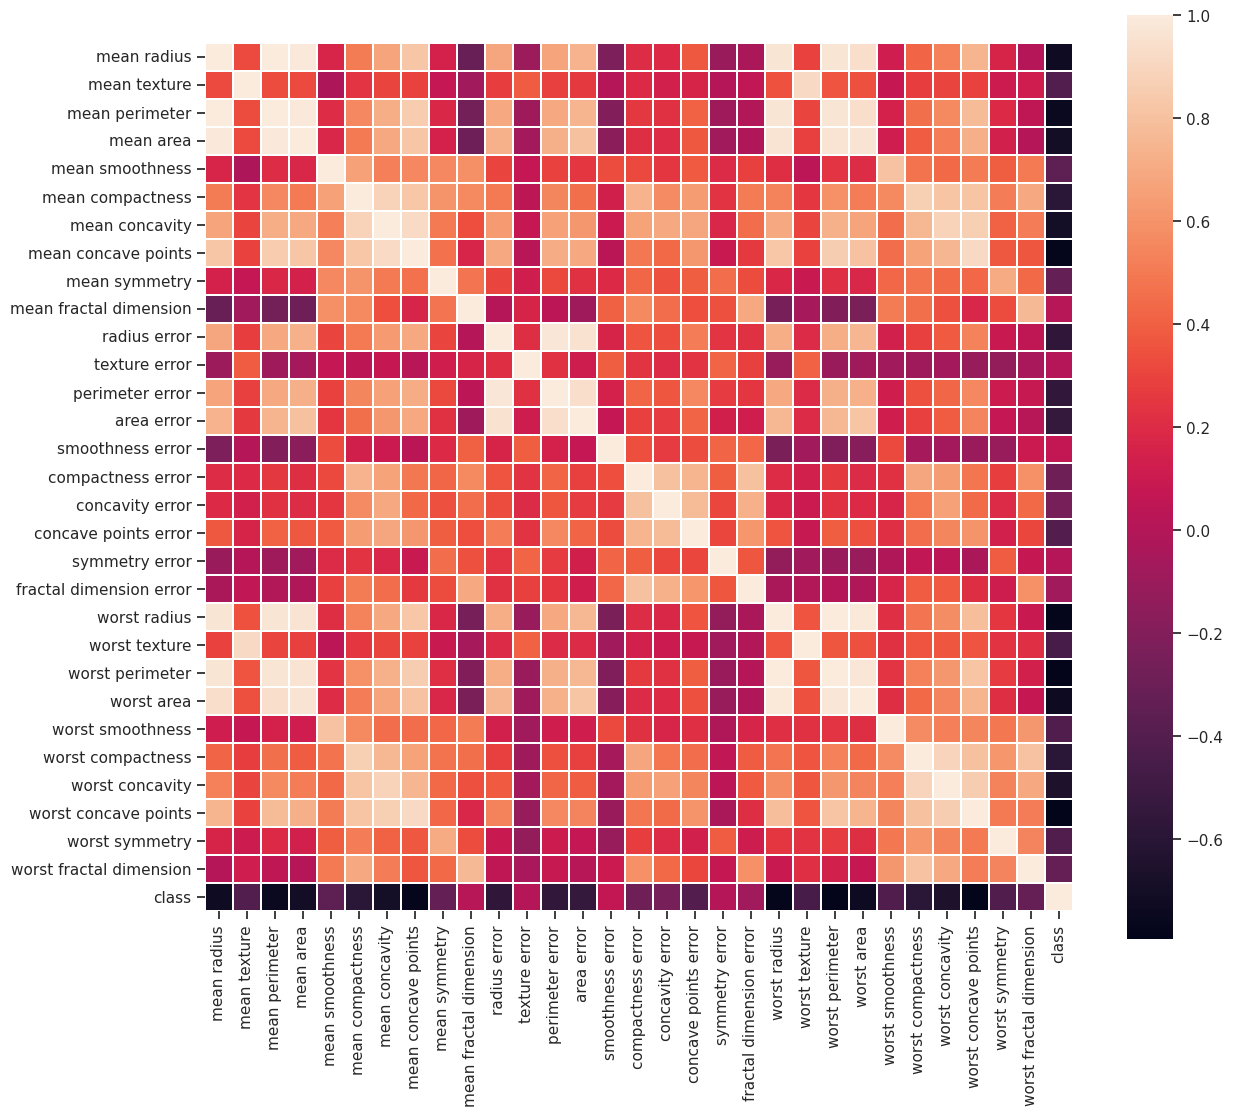

In [7]:
sns.set(style='ticks', color_codes=True)
plt.figure(figsize=(14, 12))
sns.heatmap(data.astype(float).corr(), linewidths=0.1, square=True, linecolor='white', annot=False)
plt.show()

Test-Train split for CLIENT 1

In [8]:
X1 = X.iloc[0:100, :]
Y1 = Y.iloc[0:100]

In [9]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X1, Y1, test_size=0.1, stratify=Y1, random_state= 1)
X_binarised_train = X_train_1.apply(pd.cut, bins=2, labels=[1, 0])
X_binarised_test = X_test_1.apply(pd.cut, bins=2, labels=[1, 0])
X_train_1 = X_binarised_train.values
X_test_1 = X_binarised_test.values

Test-Train split for CLIENT 2

In [10]:
X2 = X.iloc[100:200, :]
Y2 = Y.iloc[100:200]

In [11]:
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X2, Y2, test_size=0.1, stratify=Y2, random_state= 1)
X_binarised_train = X_train_2.apply(pd.cut, bins=2, labels=[1, 0])
X_binarised_test = X_test_2.apply(pd.cut, bins=2, labels=[1, 0])
X_train_2 = X_binarised_train.values
X_test_2 = X_binarised_test.values

#**Models**

SINGLE-LAYER PERCEPTRON

In [12]:
class Perceptron:
  def __init__(self, w=None, b=None):
    self.w = w # w is an array (vector)
    self.b = b # b is a scalar

  def model(self, x):
    """Given an X, compute Y. It works for a particular value of X (Not the entire vector)"""
    return 1 if (np.dot(self.w, x) >= self.b) else 0

  def predict(self, X):
    """Works with a vector"""
    Y = []
    for x in X:
      result = self.model(x)
      Y.append(result)
    return np.array(Y)

  def fit(self, X, Y):
    """Given X, Y of training data, learn parameters"""
    self.w = np.ones(X.shape[1])  # Initializing w vector having size equal to number of columns in X, with all ones as values.
    self.b = 0
    for x, y in zip(X, Y):      # For each value in x train data, we calculate predicted value
      y_pred = self.model(x)
      if y == 1 and y_pred == 0:  # ground truth is 1 and predicted value is 0
        self.w = self.w + x
        self.b = self.b + 1
      elif y == 0 and y_pred == 1:  # ground truth is 0 and predicted value is 1
        self.w = self.w - x
        self.b = self.b - 1

SVM

In [13]:
from sklearn.svm import SVC

MULTI-LAYER PERCEPTRON

In [14]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(30, activation='relu', input_shape=(30,)),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [15]:
class Client:
    def __init__(self, x_train, y_train):
        self.model = create_model()
        self.x_train = x_train
        self.y_train = y_train

    def train(self, epochs=5):
        self.model.fit(self.x_train, self.y_train, epochs=epochs, verbose=0)
        loss, accuracy = self.model.evaluate(self.x_train, self.y_train, verbose=0)
        print(accuracy)

class Server:
    def __init__(self, clients):
        self.clients = clients
        self.global_model = create_model()

    def aggregate(self):
        global_weights = self.global_model.get_weights()
        client_weights = [client.model.get_weights() for client in self.clients]

        # Compute the sum of weights
        sum_weights = [np.zeros_like(w) for w in global_weights]
        for weights in client_weights:
            for i, w in enumerate(weights):
                sum_weights[i] += w

        # Compute the average of weights
        avg_weights = [w / len(self.clients) for w in sum_weights]
        self.global_model.set_weights(avg_weights)

        for client in self.clients:
            client.model.set_weights(avg_weights)

    def train_global_model(self, num_epochs=5):
        for epoch in range(num_epochs):
            print("epoch ", epoch)
            client_num = 1
            for client in self.clients:
                print("client", client_num, "accuracy:", end=" ")
                client_num += 1
                client.train()
            print()
            self.aggregate()

#**Client 1**

PERCEPTRON

In [16]:
client1_perceptron = Perceptron()

In [17]:
client1_perceptron.fit(X_train_1, Y_train_1)

In [18]:
y_pred_train = client1_perceptron.predict(X_test_1)
print(accuracy_score(y_pred_train, Y_test_1))

0.7


In [19]:
c1_w = client1_perceptron.w
c1_b = client1_perceptron.b
print(c1_w, c1_b)

[2.0 2.0 1.0 -1.0 -1.0 0.0 1.0 0.0 0.0 -2.0 1.0 -3.0 -1.0 -1.0 -5.0 -2.0
 -4.0 -2.0 -3.0 -5.0 3.0 3.0 1.0 0.0 2.0 2.0 1.0 9.0 2.0 0.0] -5


SVM

In [20]:
client1_svm = SVC(kernel='linear')

In [21]:
client1_svm.fit(X_train_1, Y_train_1)

SVC(kernel='linear')

In [22]:
y_pred = client1_svm.predict(X_test_1)
print(accuracy_score(y_pred, Y_test_1))

0.9


In [23]:
c1_intercept_ = client1_svm.intercept_
print(c1_intercept_)

[-2.74954875]


MULTI LAYER PERCEPTRON

In [24]:
x = np.asarray(X_train_1).astype('float32')
y = np.asarray(Y_train_1).astype('float32')

In [25]:
client1_mlp = Client(x, y)

#**Client 2**

PERCEPTRON

In [26]:
client2_perceptron = Perceptron()

In [27]:
client2_perceptron.fit(X_train_2, Y_train_2)

In [28]:
y_pred_train = client2_perceptron.predict(X_test_2)
print(accuracy_score(y_pred_train, Y_test_2))

0.9


In [29]:
c2_w = client2_perceptron.w
c2_b = client2_perceptron.b
print(c2_w, c2_b)

[2.0 3.0 2.0 0.0 -3.0 0.0 -1.0 0.0 0.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
 -1.0 -1.0 -1.0 -1.0 1.0 4.0 1.0 0.0 0.0 -1.0 0.0 6.0 0.0 0.0] -2


SVM

In [30]:
client2_svm = SVC(kernel='linear')

In [31]:
client2_svm.fit(X_train_2, Y_train_2)

SVC(kernel='linear')

In [32]:
y_pred = client2_svm.predict(X_test_2)
print(accuracy_score(y_pred, Y_test_2))

1.0


In [33]:
c2_intercept_ = client2_svm.intercept_
print(c2_intercept_)

[-1.75580546]


MULTI LAYER PERCEPTRON

In [50]:
x = np.asarray(X_train_2).astype('float32')
y = np.asarray(Y_train_2).astype('float32')

In [67]:
client2_mlp = Client(x, y)

#**Server**

PERCEPTRON

In [52]:
new_w = (c1_w + c2_w)/2
new_b = (c1_b + c2_b)/2

Client 1

In [53]:
client1_perceptron.w = new_w
client1_perceptron.b = new_b

In [54]:
client1_perceptron.fit(X_train_1, Y_train_1)

In [55]:
y_pred_train = client1_perceptron.predict(X_test_1)
print(accuracy_score(y_pred_train, Y_test_1))

0.7


Client 2

In [56]:
client2_perceptron.w = new_w
client2_perceptron.b = new_b

In [57]:
client2_perceptron.fit(X_train_2, Y_train_2)

In [58]:
y_pred_train = client2_perceptron.predict(X_test_2)
print(accuracy_score(y_pred_train, Y_test_2))

0.9


SVM

In [59]:
new_intercept_ = (c1_intercept_ + c2_intercept_) / 2

Client 1

In [60]:
client1_svm.intercept_ = new_intercept_

In [61]:
client1_svm.fit(X_train_1, Y_train_1)

SVC(kernel='linear')

In [62]:
y_pred = client1_svm.predict(X_test_1)
print(accuracy_score(y_pred, Y_test_1))

0.9


Client 2

In [63]:
client2_svm.intercept_ = new_intercept_

In [64]:
client2_svm.fit(X_train_2, Y_train_2)

SVC(kernel='linear')

In [65]:
y_pred = client2_svm.predict(X_test_2)
print(accuracy_score(y_pred, Y_test_2))

1.0


MULTI LAYER PERCEPTRON

In [68]:
server_mlp = Server([client1_mlp, client2_mlp])
server_mlp.train_global_model()

epoch  0
client 1 accuracy: 0.6000000238418579
client 2 accuracy: 0.8111110925674438

epoch  1
client 1 accuracy: 0.6000000238418579
client 2 accuracy: 0.800000011920929

epoch  2
client 1 accuracy: 0.6222222447395325
client 2 accuracy: 0.7777777910232544

epoch  3
client 1 accuracy: 0.644444465637207
client 2 accuracy: 0.7444444298744202

epoch  4
client 1 accuracy: 0.699999988079071
client 2 accuracy: 0.7444444298744202

